In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [4]:
merged = pd.read_csv('../data/new_merged_data.csv', parse_dates=['trade_date'])
merged.tail()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Crossed,Fee,trade_date,sentiment_date,classification,sentiment_score
211219,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,382.2,420.80,SELL,2025-04-25 15:35:00,7546.6,CLOSE LONG,-20.2566,False,0.042080,2025-04-25,2025-04-25,Greed,3.0
211220,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,2124.1,2338.63,SELL,2025-04-25 15:35:00,7164.4,CLOSE LONG,-112.5773,False,0.233863,2025-04-25,2025-04-25,Greed,3.0
211221,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,423.4,466.16,SELL,2025-04-25 15:35:00,5040.3,CLOSE LONG,-22.4402,False,0.046616,2025-04-25,2025-04-25,Greed,3.0
211222,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,3599.8,3963.38,SELL,2025-04-25 15:35:00,4616.9,CLOSE LONG,-190.7894,False,0.396337,2025-04-25,2025-04-25,Greed,3.0
211223,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.101,1017.1,1119.83,SELL,2025-04-25 15:35:00,1017.1,CLOSE LONG,-53.9063,False,0.111982,2025-04-25,2025-04-25,Greed,3.0


In [3]:
corr = merged[['Closed PnL', 'sentiment_score']].corr()
corr


,Closed PnL,sentiment_score
Closed PnL,1.00000,0.00597
sentiment_score,0.00597,1.00000


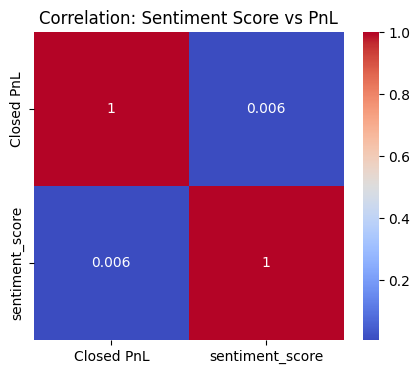

In [5]:
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation: Sentiment Score vs PnL")
plt.show()


C:\Users\ankit\AppData\Local\Temp\ipykernel_7288\4091597942.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fear, label='Fear', shade=True)
C:\Users\ankit\AppData\Local\Temp\ipykernel_7288\4091597942.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(greed, label='Greed', shade=True)


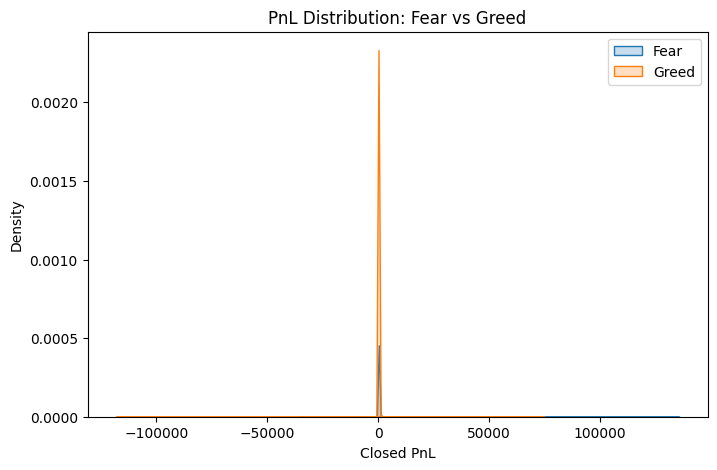

In [6]:
fear = merged[merged['classification'].isin(['Fear', 'Extreme Fear'])]['Closed PnL']
greed = merged[merged['classification'].isin(['Greed', 'Extreme Greed'])]['Closed PnL']

plt.figure(figsize=(8,5))
sns.kdeplot(fear, label='Fear', shade=True)
sns.kdeplot(greed, label='Greed', shade=True)
plt.title("PnL Distribution: Fear vs Greed")
plt.legend()
plt.show()


In [7]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(fear, greed, alternative='two-sided')
u_stat, p_value


(np.float64(3725766115.0), np.float64(0.0009540068051976515))

In [8]:
daily_df = merged.groupby('trade_date').agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    trades=('Account', 'count'),
    sentiment=('sentiment_score', 'mean')
).reset_index()

daily_df.head()


,trade_date,total_pnl,avg_pnl,trades,sentiment
0,2023-05-01,0.000000,0.000000,3,3.0
1,2023-12-05,0.000000,0.000000,9,4.0
2,2023-12-14,-205.434737,-18.675885,11,3.0
3,2023-12-15,-24.632034,-12.316017,2,3.0
4,2023-12-16,0.000000,0.000000,3,3.0


In [9]:
model = smf.ols('total_pnl ~ sentiment + trades', data=daily_df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_pnl   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     35.58
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           3.97e-15
Time:                        15:37:40   Log-Likelihood:                -6002.7
No. Observations:                 479   AIC:                         1.201e+04
Df Residuals:                     476   BIC:                         1.202e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8660.7544   8586.099      1.009      0.314   -8210.589    2.55e+04
sentiment   -490.7457   2819.040     -0.174      0.862   -6030.047    5048.556
trades        31.8359      3.916      8.130      0.000      24.142      39.530
==============================================================================
Omnibus:                      311.039   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28327.926
Skew:                           1.931   Prob(JB):                         0.00
Kurtosis:                      40.476   Cond. No.                     2.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
ml_df = merged[['Closed PnL', 'sentiment_score', 'Side', 'Size USD', 'Execution Price']]
ml_df['is_win'] = merged['Closed PnL'] > 0

# encode Side
ml_df['Side'] = ml_df['Side'].map({'BUY':1, 'SELL':0})

ml_df.dropna(inplace=True)
ml_df.head()


C:\Users\ankit\AppData\Local\Temp\ipykernel_7288\2576678681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_df['is_win'] = merged['Closed PnL'] > 0
C:\Users\ankit\AppData\Local\Temp\ipykernel_7288\2576678681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_df['Side'] = ml_df['Side'].map({'BUY':1, 'SELL':0})
C:\Users\ankit\AppData\Local\Temp\ipykernel_7288\2576678681.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

,Closed PnL,sentiment_score,Side,Size USD,Execution Price,is_win
0,0.0,4.0,1,7872.16,7.9769,False
1,0.0,4.0,1,127.68,7.9800,False
2,0.0,4.0,1,1150.63,7.9855,False
3,0.0,4.0,1,1142.04,7.9874,False
4,0.0,4.0,1,69.75,7.9894,False


In [11]:
X = ml_df[['sentiment_score', 'Side', 'Size USD', 'Execution Price']]
y = ml_df['is_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [12]:
X.head()

,sentiment_score,Side,Size USD,Execution Price
0,4.0,1,7872.16,7.9769
1,4.0,1,127.68,7.9800
2,4.0,1,1150.63,7.9855
3,4.0,1,1142.04,7.9874
4,4.0,1,69.75,7.9894


In [13]:
y.head()

0    False
1    False
2    False
3    False
4    False
Name: is_win, dtype: bool

In [14]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

       False       0.91      0.92      0.92     30963
        True       0.89      0.88      0.88     21842

    accuracy                           0.90     52805
   macro avg       0.90      0.90      0.90     52805
weighted avg       0.90      0.90      0.90     52805



In [16]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

search.fit(X_train, y_train)
best_model = search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [19]:
print(search.best_params_)
print(search.best_score_)




{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
0.8728564309165968


In [20]:
best_model = search.best_estimator_
best_preds = best_model.predict(X_test)
print(classification_report(y_test, best_preds))


              precision    recall  f1-score   support

       False       0.92      0.92      0.92     30963
        True       0.89      0.88      0.89     21842

    accuracy                           0.91     52805
   macro avg       0.90      0.90      0.90     52805
weighted avg       0.91      0.91      0.91     52805



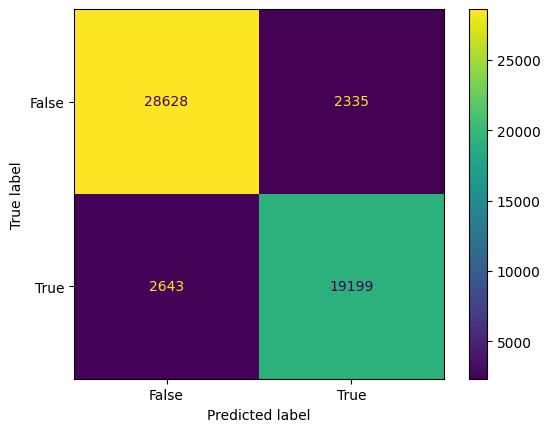

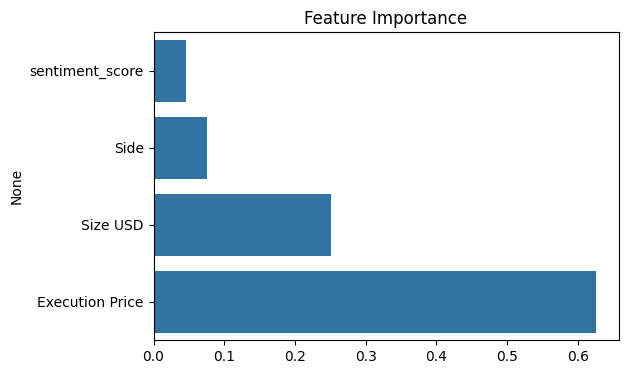

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()
#!/usr/bin/env python3
plt.figure(figsize=(6,4))
sns.barplot(x=best_model.feature_importances_, y=X.columns)
plt.title("Feature Importance")
plt.show()

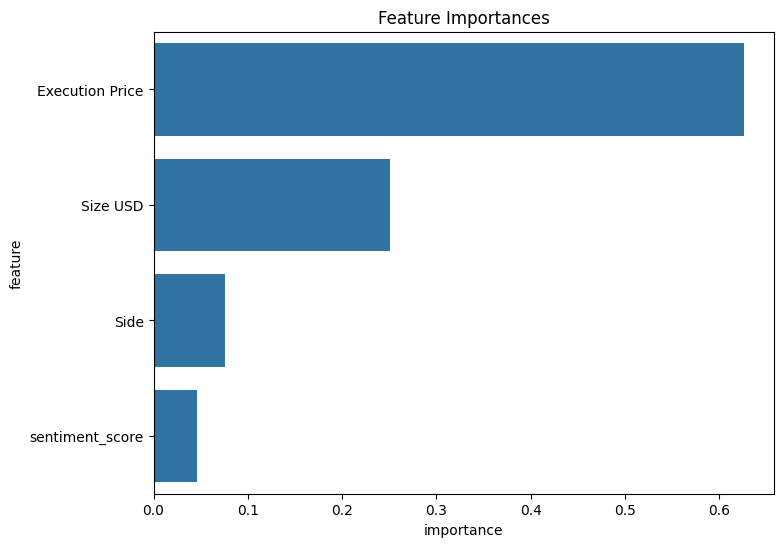

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
features = X_train.columns

fi = pd.DataFrame({"feature": features, "importance": importances})
fi.sort_values("importance", ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=fi.sort_values("importance", ascending=False))
plt.title("Feature Importances")
plt.show()

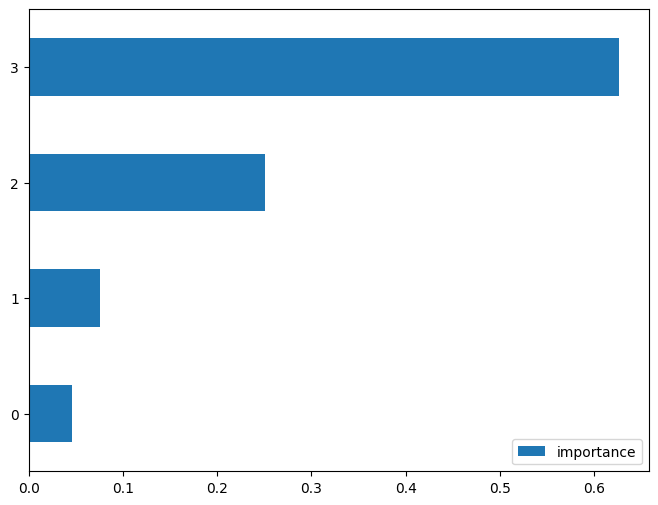

In [25]:
fi.sort_values("importance")[-15:].plot(kind="barh", figsize=(8,6))
plt.show()


In [28]:
from sklearn.preprocessing import LabelEncoder

side_encoder = LabelEncoder()
merged['Side'] = side_encoder.fit_transform(merged['Side'])


In [30]:
new_trade = pd.DataFrame([{
    "Execution Price": 1.09,
    "Size Tokens": 500,
    "Size USD": 550,
    "Side": "SELL",
    "Start Position": 2000,
    "Fee": 0.01,
    "sentiment_score": 2
}])
# Encode Side with the same encoder
new_trade['Side'] = side_encoder.transform(new_trade['Side'])

# Select same columns as train
new_trade = new_trade[X_train.columns]

# Predict
pred = best_model.predict(new_trade)
print("Prediction:", pred)

Prediction: [False]
